# TomatoMAP-Cls Trainer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import argparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import ImageDraw, ImageFont, Image
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import (
    MobileNet_V3_Large_Weights,
    MobileNet_V3_Small_Weights,
    MobileNet_V2_Weights,
    ResNet18_Weights,
)

# env checker
print("Environment checker:")
print(f"  PyTorch version: {torch.__version__}")
print(f"  CUDA version: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU device: {torch.cuda.get_device_name(0)}")
    print(f"  GPU ram: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Environment checker:
  PyTorch version: 2.7.1+cu126
  CUDA version: True
  GPU device: Tesla V100-PCIE-16GB
  GPU ram: 15.8 GB


In [2]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"model saved at: {path}")

def load_model(model, path, device='cpu'):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"model loaded from: {path}")

def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_checkpoint(path, model, optimizer, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"from epoch {start_epoch} re-training")
    return start_epoch

def get_font(size=30, bold=False):
    font_paths = [
        "C:/Windows/Fonts/arialbd.ttf" if bold else "C:/Windows/Fonts/arial.ttf",
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf" if bold else "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        "/System/Library/Fonts/Supplemental/Arial-Bold.ttf" if bold else "/System/Library/Fonts/Supplemental/Arial.ttf",
    ]
    for path in font_paths:
        try:
            return ImageFont.truetype(path, size=size)
        except:
            continue
    return ImageFont.load_default()

def denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(img_tensor.device)
    return torch.clamp(img_tensor * std + mean, 0, 1)

def get_model(name, num_classes, pretrained=True):
    print(f"build model: {name}, class number: {num_classes}")
    
    if name == 'mobilenet_v3_large':
        weights = MobileNet_V3_Large_Weights.DEFAULT if pretrained else None
        model = models.mobilenet_v3_large(weights=weights)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif name == 'mobilenet_v3_small':
        weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
        model = models.mobilenet_v3_small(weights=weights)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif name == 'mobilenet_v2':
        weights = MobileNet_V2_Weights.DEFAULT if pretrained else None
        model = models.mobilenet_v2(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == 'resnet18':
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Model {name} not supported.")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"parameter info: Total: {total_params:,}, Trainable: {trainable_params:,}")
    
    return model

class BBCHDataset(Dataset):
    
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        
        # get all classes
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                              if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"loading {split} dataset: {len(self.samples)} images, {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"failed to load image: {img_path}, error: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# data enhance
def get_transforms(target_size=(640, 640)):
    train_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def get_dataloaders(data_dir, batch_size=32, target_size=(640, 640), num_workers=8, include_test=False):
    print(f"building dataloader: {data_dir}")
    
    train_transform, val_transform = get_transforms(target_size)
    
    train_dataset = BBCHDataset(data_dir, 'train', train_transform)
    val_dataset = BBCHDataset(data_dir, 'val', val_transform)

    # for windows users
    import platform
    if platform.system() == 'Windows':
        num_workers = 0
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=torch.cuda.is_available()
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=torch.cuda.is_available()
    )
    
    test_loader = None
    if include_test:
        test_dir = os.path.join(data_dir, 'test')
        if os.path.exists(test_dir):
            test_dataset = BBCHDataset(data_dir, 'test', val_transform)
            test_loader = DataLoader(
                test_dataset, batch_size=batch_size, shuffle=False,
                num_workers=num_workers, pin_memory=torch.cuda.is_available()
            )
        else:
            print("test set not found, using val as test")
            test_loader = val_loader

    return train_loader, val_loader, test_loader

In [3]:
CLASSIFICATION_CONFIG = {
    'data_dir': 'TomatoMAP/TomatoMAP-Cls',
    'model_name': 'mobilenet_v3_large',  # 'mobilenet_v3_small', 'mobilenet_v2', 'resnet18'
    'num_classes': 50,
    'batch_size': 32,
    'num_epochs': 30,
    'learning_rate': 1e-4,
    'target_size': (640, 640),
    'patience': 3,
    'save_interval': 20
}

print("config:")
for key, value in CLASSIFICATION_CONFIG.items():
    print(f"  {key}: {value}")

config:
  data_dir: TomatoMAP/TomatoMAP-Cls
  model_name: mobilenet_v3_large
  num_classes: 50
  batch_size: 32
  num_epochs: 30
  learning_rate: 0.0001
  target_size: (640, 640)
  patience: 3
  save_interval: 20


TomatoMAP-Cls Trainer
data founded at: TomatoMAP/TomatoMAP-Cls
TomatoMAP-Cls is well structured.

 training config:
   data_dir: TomatoMAP/TomatoMAP-Cls
   model_name: mobilenet_v3_large
   num_classes: 50
   batch_size: 32
   num_epochs: 30
   learning_rate: 0.0001
   target_size: (640, 640)
   patience: 3
   save_interval: 20

 training start.
Using device: cuda
building dataloader: TomatoMAP/TomatoMAP-Cls
loading train dataset: 45099 images, 50 classes
loading val dataset: 12870 images, 50 classes
loading test dataset: 6495 images, 50 classes
build model: mobilenet_v3_large, class number: 50
parameter info: Total: 4,266,082, Trainable: 4,266,082
Training start with 30 epoch(s),


Epoch 1/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.67it/s, Loss=1.8581, Acc=40.05%]



 Epoch 1/30:
  Train - Loss: 2.1123, Acc: 32.31%
  Val - Loss: 1.6768, Acc: 40.05%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 40.05%
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|████████████████████| 403/403 [01:07<00:00,  5.99it/s, Loss=0.9373, Acc=45.84%]



 Epoch 2/30:
  Train - Loss: 1.6399, Acc: 42.30%
  Val - Loss: 1.4930, Acc: 45.84%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 45.84%
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.64it/s, Loss=0.9665, Acc=47.71%]



 Epoch 3/30:
  Train - Loss: 1.4578, Acc: 47.10%
  Val - Loss: 1.4351, Acc: 47.71%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 47.71%
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|████████████████████| 403/403 [01:06<00:00,  6.06it/s, Loss=1.2630, Acc=53.02%]



 Epoch 4/30:
  Train - Loss: 1.3072, Acc: 51.96%
  Val - Loss: 1.2602, Acc: 53.02%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 53.02%
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.63it/s, Loss=1.0445, Acc=54.39%]



 Epoch 5/30:
  Train - Loss: 1.1802, Acc: 56.47%
  Val - Loss: 1.2064, Acc: 54.39%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 54.39%
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|████████████████████| 403/403 [01:02<00:00,  6.47it/s, Loss=0.5300, Acc=58.96%]



 Epoch 6/30:
  Train - Loss: 1.0670, Acc: 60.32%
  Val - Loss: 1.0961, Acc: 58.96%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 58.96%
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|████████████████████| 403/403 [01:04<00:00,  6.29it/s, Loss=0.5100, Acc=60.51%]



 Epoch 7/30:
  Train - Loss: 0.9635, Acc: 64.10%
  Val - Loss: 1.0496, Acc: 60.51%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 60.51%
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|████████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.4854, Acc=62.77%]



 Epoch 8/30:
  Train - Loss: 0.8680, Acc: 67.50%
  Val - Loss: 0.9902, Acc: 62.77%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 62.77%
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|████████████████████| 403/403 [01:01<00:00,  6.58it/s, Loss=0.3427, Acc=64.92%]



 Epoch 9/30:
  Train - Loss: 0.7869, Acc: 70.62%
  Val - Loss: 0.9535, Acc: 64.92%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 64.92%
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.55it/s, Loss=0.1160, Acc=66.73%]



 Epoch 10/30:
  Train - Loss: 0.7029, Acc: 73.65%
  Val - Loss: 0.8825, Acc: 66.73%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 66.73%
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.9800, Acc=70.13%]



 Epoch 11/30:
  Train - Loss: 0.6342, Acc: 76.41%
  Val - Loss: 0.8193, Acc: 70.13%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 70.13%
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|███████████████████| 403/403 [00:59<00:00,  6.74it/s, Loss=0.5220, Acc=69.18%]



 Epoch 12/30:
  Train - Loss: 0.5705, Acc: 78.85%
  Val - Loss: 0.8643, Acc: 69.18%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|███████████████████| 403/403 [00:59<00:00,  6.76it/s, Loss=0.4900, Acc=70.23%]



 Epoch 13/30:
  Train - Loss: 0.5188, Acc: 80.82%
  Val - Loss: 0.8389, Acc: 70.23%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 70.23%
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.53it/s, Loss=0.1427, Acc=72.19%]



 Epoch 14/30:
  Train - Loss: 0.4690, Acc: 82.79%
  Val - Loss: 0.7842, Acc: 72.19%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 72.19%
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.67it/s, Loss=0.0423, Acc=73.65%]



 Epoch 15/30:
  Train - Loss: 0.4207, Acc: 84.51%
  Val - Loss: 0.7464, Acc: 73.65%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 73.65%
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.59it/s, Loss=0.0441, Acc=74.16%]



 Epoch 16/30:
  Train - Loss: 0.3839, Acc: 86.13%
  Val - Loss: 0.7422, Acc: 74.16%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 74.16%
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.60it/s, Loss=0.0240, Acc=73.03%]



 Epoch 17/30:
  Train - Loss: 0.3403, Acc: 87.79%
  Val - Loss: 0.8209, Acc: 73.03%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.67it/s, Loss=0.0083, Acc=75.19%]



 Epoch 18/30:
  Train - Loss: 0.3198, Acc: 88.62%
  Val - Loss: 0.7634, Acc: 75.19%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 75.19%
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.2833, Acc=75.68%]



 Epoch 19/30:
  Train - Loss: 0.2938, Acc: 89.24%
  Val - Loss: 0.7364, Acc: 75.68%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 75.68%
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.57it/s, Loss=0.0088, Acc=74.93%]



 Epoch 20/30:
  Train - Loss: 0.2635, Acc: 90.42%
  Val - Loss: 0.7816, Acc: 74.93%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|███████████████████| 403/403 [01:03<00:00,  6.33it/s, Loss=0.7884, Acc=76.23%]



 Epoch 21/30:
  Train - Loss: 0.2497, Acc: 91.08%
  Val - Loss: 0.7626, Acc: 76.23%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 76.23%
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.64it/s, Loss=0.0347, Acc=75.87%]



 Epoch 22/30:
  Train - Loss: 0.2265, Acc: 92.02%
  Val - Loss: 0.8087, Acc: 75.87%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|███████████████████| 403/403 [01:06<00:00,  6.06it/s, Loss=0.2525, Acc=76.99%]



 Epoch 23/30:
  Train - Loss: 0.2128, Acc: 92.44%
  Val - Loss: 0.7541, Acc: 76.99%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 76.99%
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|███████████████████| 403/403 [01:05<00:00,  6.11it/s, Loss=0.0584, Acc=77.33%]



 Epoch 24/30:
  Train - Loss: 0.2004, Acc: 92.88%
  Val - Loss: 0.7255, Acc: 77.33%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 77.33%
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|███████████████████| 403/403 [01:04<00:00,  6.23it/s, Loss=0.0602, Acc=77.47%]



 Epoch 25/30:
  Train - Loss: 0.1869, Acc: 93.45%
  Val - Loss: 0.7610, Acc: 77.47%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 77.47%
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|███████████████████| 403/403 [01:01<00:00,  6.58it/s, Loss=0.0157, Acc=78.09%]



 Epoch 26/30:
  Train - Loss: 0.1716, Acc: 93.95%
  Val - Loss: 0.7465, Acc: 78.09%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 78.09%
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|███████████████████| 403/403 [00:59<00:00,  6.73it/s, Loss=0.2581, Acc=77.28%]



 Epoch 27/30:
  Train - Loss: 0.1627, Acc: 94.37%
  Val - Loss: 0.7966, Acc: 77.28%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.62it/s, Loss=0.0969, Acc=79.19%]



 Epoch 28/30:
  Train - Loss: 0.1564, Acc: 94.52%
  Val - Loss: 0.7067, Acc: 79.19%
  lr: 1.00e-04
model saved at: cls/runs/mobilenet_v3_large_cls/best_mobilenet_v3_large.pth
  best val acc: 79.19%
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|███████████████████| 403/403 [01:04<00:00,  6.28it/s, Loss=0.2542, Acc=77.54%]



 Epoch 29/30:
  Train - Loss: 0.1497, Acc: 94.85%
  Val - Loss: 0.8152, Acc: 77.54%
  lr: 1.00e-04
  val acc not raised (1/3)
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|███████████████████| 403/403 [01:00<00:00,  6.68it/s, Loss=0.1726, Acc=79.02%]



 Epoch 30/30:
  Train - Loss: 0.1404, Acc: 95.06%
  Val - Loss: 0.7246, Acc: 79.02%
  lr: 1.00e-05
  val acc not raised (2/3)
------------------------------------------------------------
model saved at: cls/runs/mobilenet_v3_large_cls/final_mobilenet_v3_large.pth

 TomatoMAP-Cls is trained!
  best val acc: 79.19%
  model saved at: cls/runs/mobilenet_v3_large_cls


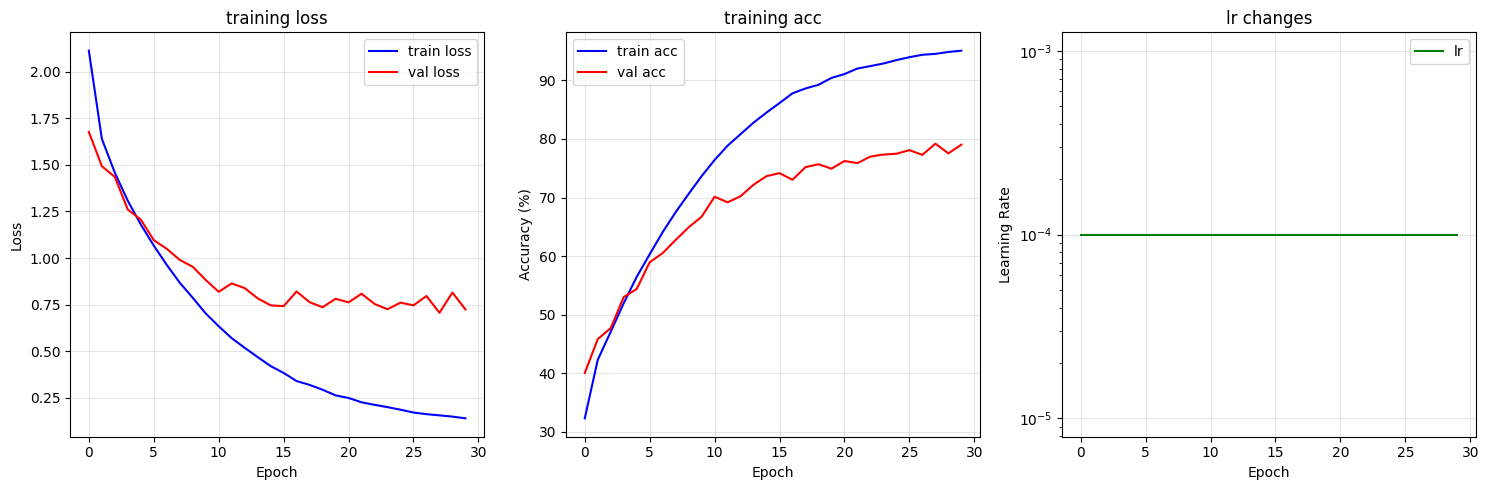

 training log saved at: cls/runs/mobilenet_v3_large_cls/training_history.csv


 training finished!
   best val acc is: 79.19%
   model saved at: cls/runs/mobilenet_v3_large_cls

 evaluating on test subset...


evaluating: 100%|███████████████████████████████████████| 203/203 [00:31<00:00,  6.42it/s, Acc=79.01%]


 test subset acc: 79.01%

 building confusion matrix


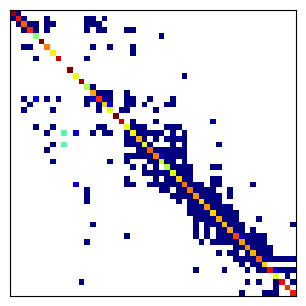


 Evaluation results:
   best val acc: 79.19%
   test acc: 79.01%
   class number: 50
   test data size: 6495
   results saved at: cls/runs/mobilenet_v3_large_cls
   GGWP!


In [4]:
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    output_dir = Path(f"cls/runs/{config['model_name']}_cls")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    train_loader, val_loader, test_loader = get_dataloaders(
        config['data_dir'], 
        batch_size=config['batch_size'],
        target_size=config['target_size'],
        num_workers=8,
        include_test=True
    )
    
    model = get_model(config['model_name'], config['num_classes'], pretrained=True)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=0.01)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"Training start with {config['num_epochs']} epoch(s),")
    
    for epoch in range(config['num_epochs']):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]")
        
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            current_acc = 100 * train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]")
            
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                current_acc = 100 * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\n Epoch {epoch+1}/{config['num_epochs']}:")
        print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"  lr: {current_lr:.2e}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = output_dir / f"best_{config['model_name']}.pth"
            save_model(model, best_model_path)
            patience_counter = 0
            print(f"  best val acc: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"  val acc not raised ({patience_counter}/{config['patience']})")
        
        if (epoch + 1) % config['save_interval'] == 0:
            checkpoint_path = output_dir / f"checkpoint_epoch_{epoch+1}.pth"
            save_checkpoint(model, optimizer, epoch, checkpoint_path)
        
        if patience_counter >= config['patience']:
            print(f"\n Trigger early stop. Val acc has {config['patience']} epochs no improve")
            break
        
        print("-" * 60)
    
    final_model_path = output_dir / f"final_{config['model_name']}.pth"
    save_model(model, final_model_path)
    
    print(f"\n TomatoMAP-Cls is trained!")
    print(f"  best val acc: {best_val_acc:.2f}%")
    print(f"  model saved at: {output_dir}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='train loss', color='blue')
    plt.plot(val_losses, label='val loss', color='red')
    plt.title('training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='train acc', color='blue')
    plt.plot(val_accuracies, label='val acc', color='red')
    plt.title('training acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    lrs = []
    for i in range(len(train_losses)):
        if i < 30:
            lrs.append(config['learning_rate'])
        elif i < 60:
            lrs.append(config['learning_rate'] * 0.1)
        else:
            lrs.append(config['learning_rate'] * 0.01)
    plt.plot(lrs, label='lr', color='green')
    plt.title('lr changes')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    history_df = pd.DataFrame({
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    })
    history_df.to_csv(output_dir / 'training_history.csv', index=False)
    print(f" training log saved at: {output_dir / 'training_history.csv'}")
    
    return model, best_val_acc, output_dir, test_loader


print("=" * 60)
print("TomatoMAP-Cls Trainer")
print("=" * 60)

if not os.path.exists(CLASSIFICATION_CONFIG['data_dir']):
    print(f"dataset not exist")
    print(f"   path: {CLASSIFICATION_CONFIG['data_dir']}")
    print(f"   please check data structure")
else:
    print(f"data founded at: {CLASSIFICATION_CONFIG['data_dir']}")
    
    train_dir = os.path.join(CLASSIFICATION_CONFIG['data_dir'], 'train')
    val_dir = os.path.join(CLASSIFICATION_CONFIG['data_dir'], 'val')
    test_dir = os.path.join(CLASSIFICATION_CONFIG['data_dir'], 'test')
    
    if not os.path.exists(train_dir):
        print(f"training subset not exist: {train_dir}")
    elif not os.path.exists(val_dir):
        print(f"val subset not exist: {val_dir}")
    elif not os.path.exists(test_dir):
        print(f"test subset not exist: {test_dir}")
        print(f"   using val subset for test")
    else:
        print(f"TomatoMAP-Cls is well structured.")
        
        print("\n training config:")
        for key, value in CLASSIFICATION_CONFIG.items():
            print(f"   {key}: {value}")
        
        print("\n training start.")
        
        try:
            model, best_acc, output_dir, test_loader = train_model(CLASSIFICATION_CONFIG)
            
            print("\n" + "=" * 60)
            print("\n training finished!")
            print(f"   best val acc is: {best_acc:.2f}%")
            print(f"   model saved at: {output_dir}")
            
            print("\n evaluating on test subset...")
            model.eval()
            test_correct = 0
            test_total = 0
            test_predictions = []
            test_labels = []
            
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            with torch.no_grad():
                test_pbar = tqdm(test_loader, desc="evaluating")
                for images, labels in test_pbar:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                    test_predictions.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    
                    current_acc = 100 * test_correct / test_total
                    test_pbar.set_postfix({'Acc': f'{current_acc:.2f}%'})
            
            test_accuracy = 100 * test_correct / test_total
            print(f" test subset acc: {test_accuracy:.2f}%")

            print("\n building confusion matrix")
            
            train_dataset = test_loader.dataset
            class_names = train_dataset.classes
            
            cm = confusion_matrix(test_labels, test_predictions)
            
            cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
            cm_df.to_csv(output_dir / 'confusion_matrix.csv')

            normalized_cm = cm_df.div(cm_df.sum(axis=1), axis=0).fillna(0)
            
            matrix = normalized_cm.T.to_numpy()
            
            from matplotlib import rcParams
            # rcParams['font.family'] = 'Calibri' # Ubuntu doesn't own this when training on ubuntu VM
            rcParams['font.size'] = 8
            
            masked_matrix = np.ma.masked_where(matrix == 0, matrix)
            
            from matplotlib.colors import Normalize
            cmap = plt.cm.jet
            cmap.set_bad(color='white')
            norm = Normalize(vmin=0.1, vmax=1)
            
            fig_width_in = 3.1
            fig_height_in = fig_width_in
            fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
            
            im = ax.imshow(masked_matrix, cmap=cmap, norm=norm)

            # For further process for publishing purpose, labels are removed :)
            ax.set_xlabel("")
            ax.set_ylabel("")
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            plt.tight_layout()
            plt.savefig(output_dir / 'normalized_confusion_matrix.png', format='png', dpi=300)
            plt.show()
            
            # plt.figure(figsize=(12, 10))
            # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            # disp.plot(cmap='Blues', values_format='d')
            # plt.title(f'Detailed Confusion Matrix (test acc: {test_accuracy:.2f}%)', fontsize=8)
            # plt.xticks(rotation=45, ha='right')
            # plt.yticks(rotation=0)
            # plt.tight_layout()
            # plt.savefig(output_dir / 'detailed_confusion_matrix.png', dpi=300, bbox_inches='tight')
            # plt.show()
            
            test_results = {
                'test_accuracy': test_accuracy,
                'total_samples': test_total,
                'correct_predictions': test_correct,
                'num_classes': len(class_names),
                'class_names': class_names
            }
            
            import json
            with open(output_dir / 'test_results.json', 'w', encoding='utf-8') as f:
                json.dump(test_results, f, indent=2, ensure_ascii=False)
            
            print("\n" + "=" * 60)
            print(" Evaluation results:")
            print(f"   best val acc: {best_acc:.2f}%")
            print(f"   test acc: {test_accuracy:.2f}%")
            print(f"   class number: {len(class_names)}")
            print(f"   test data size: {test_total}")
            print(f"   results saved at: {output_dir}")
            print(f"   GGWP!")
            print("=" * 60)
            
        except KeyboardInterrupt:
            print("\n training interruptted")
            
        except Exception as e:
            print(f"\n error during training:")
            print(f"   error info: {str(e)}")
            print("\nDetails:")
            import traceback
            traceback.print_exc()

# TomatoMAP-Det Trainer

In [5]:
from ultralytics import YOLO
from ultralytics import RTDETR

# using proper libiary?
import ultralytics
ultralytics.checks()
print(ultralytics.__file__)

Ultralytics 8.3.63 🚀 Python-3.10.0 torch-2.7.1+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
Setup complete ✅ (24 CPUs, 113.0 GB RAM, 137.6/145.2 GB disk)
/home/ubuntu/project/EoC/code/det/ultralytics/__init__.py


In [8]:
torch.use_deterministic_algorithms(False)

print("\n" + "=" * 60)
print("TomatoMAP-Det Trainer")
print("\n" + "=" * 60)

print("downloading pretrained model: ")

model = YOLO("yolo11l.pt")

print("model info: ")

train_result = model.train(
    data="det/TomatoMAP-Det.yaml",
    epochs=500,
    imgsz=640,
    device=[0],
    batch=4,
    patience=10,
    project="det/output",
    cfg="det/best_hyperparameters.yaml", # fine-tuned hyperparameters, ready to use, details please contact us per email
    #profile=True,
    plots=True
)


TomatoMAP-Det Trainer

downloading pretrained model: 
model info: 
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.10.0 torch-2.7.1+cu126 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=det/TomatoMAP-Det.yaml, epochs=500, time=None, patience=10, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=det/output, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic

/home/ubuntu/project/EoC/code/det/ultralytics/utils/torch_utils.py:258: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/home/ubuntu/project/EoC/code/det/ultralytics/utils/torch_utils.py:263: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is 

AMP: checks passed ✅


/home/ubuntu/project/EoC/code/det/ultralytics/nn/modules/block.py:1248: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * (self.head_dim ** -0.5)
/home/ubuntu/project/EoC/code/det/ultralytics/nn/modules/block.py:1252: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic

Plotting labels to det/output/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00089' and 'momentum=0.6' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.00016), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to det/output/train10
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/ubuntu/project/EoC/code/det/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/ubuntu/project/EoC/code/det/ultralytics/nn/modules/block.py:919: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it use

KeyboardInterrupt: 

# TomatoMAP-Seg Trainer

In [3]:
import os
import cv2
import json
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path
from collections import OrderedDict

# Detectron2
import detectron2
from detectron2.engine import DefaultTrainer, DefaultPredictor, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.events import get_event_storage
from detectron2.utils.logger import setup_logger

setup_logger()

print(f"  Detectron2 version: {detectron2.__version__}")

  Detectron2 version: 0.6


In [4]:
def flatten_segmentation(points):
    #format points [[x,y],[x,y]] to [x1,y1,x2,y2,...]
    return [coord for pair in points for coord in pair]

def load_categories_from_yaml(yaml_path):
    with open(yaml_path, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
    categories = []
    cat_map = {}
    cat_id = 1
    for item in data['label']:
        name = item['name']
        if name == '__background__':
            continue
        categories.append({
            "id": cat_id,
            "name": name,
            "supercategory": "none"
        })
        cat_map[name] = cat_id
        cat_id += 1
    return categories, cat_map

def convert_isat_folder_to_coco(task_dir, label_dir, yaml_path, output_dir, train_ratio=0.7, val_ratio=0.2):
    print("ISAT2COCO...")
    
    os.makedirs(output_dir, exist_ok=True)

    categories, category_map = load_categories_from_yaml(yaml_path)
    print(f"loaded {len(categories)} classes")

    if not os.path.exists(task_dir):
        print(f"image folder not exist: {task_dir}")
        return False
    
    if not os.path.exists(label_dir):
        print(f"label folder not exist: {label_dir}")
        return False

    images = [f for f in os.listdir(task_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    json_map = {os.path.splitext(f)[0]: f for f in os.listdir(label_dir) if f.endswith(".json")}

    print(f"found {len(images)} images")
    print(f"found {len(json_map)} labels")

    # matching image and labels
    dataset = []
    unmatched_images = []
    
    for img_name in tqdm(images, desc="matching image and labels"):
        base = os.path.splitext(img_name)[0]
        if base in json_map:
            dataset.append({
                "img_file": img_name,
                "json_file": json_map[base]
            })
        else:
            unmatched_images.append(img_name)

    print(f"successfully matches {len(dataset)} pairs")
    if unmatched_images:
        print(f" {len(unmatched_images)} unmatches images")

    if len(dataset) == 0:
        print("no matched pairs")
        return False

    random.shuffle(dataset)
    total = len(dataset)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    splits = {
        "train": dataset[:train_end],
        "val": dataset[train_end:val_end],
        "test": dataset[val_end:]
    }

    print(f"\n spilting dataset:")
    for split_name, split_data in splits.items():
        print(f"  {split_name}: {len(split_data)} iamges ({len(split_data)/total*100:.1f}%)")

    conversion_stats = {}
    
    for split_name, split_data in splits.items():
        if len(split_data) == 0:
            print(f" {split_name} dataset empty, skipping")
            continue
            
        print(f"\n transforming {split_name} dataset.")
        
        coco = {
            "images": [],
            "annotations": [],
            "categories": categories
        }
        ann_id = 1
        img_id = 1
        
        processed_annotations = 0
        skipped_annotations = 0

        for item in tqdm(split_data, desc=f"processing {split_name}"):
            img_path = os.path.join(task_dir, item["img_file"])
            json_path = os.path.join(label_dir, item["json_file"])

            if not os.path.exists(json_path):
                print(f" label files not exist: {json_path}")
                continue

            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    isat = json.load(f)
            except Exception as e:
                print(f"failed to load label file {json_path}: {e}")
                continue

            info = isat['info']
            coco["images"].append({
                "file_name": item["img_file"],
                "id": img_id,
                "width": info["width"],
                "height": info["height"]
            })

            for obj in isat.get('objects', []):
                cat = obj['category']
                if cat not in category_map:
                    skipped_annotations += 1
                    continue

                seg_flat = flatten_segmentation(obj["segmentation"])
                if len(seg_flat) < 6:
                    skipped_annotations += 1
                    continue

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": category_map[cat],
                    "segmentation": [seg_flat],
                    "bbox": obj["bbox"],
                    "area": obj["area"],
                    "iscrowd": obj.get("iscrowd", 0),
                    "group_id": obj.get("group", None)
                })
                ann_id += 1
                processed_annotations += 1
                
            img_id += 1

        output_file = os.path.join(output_dir, f"{split_name}.json")
        with open(output_file, "w", encoding='utf-8') as f:
            json.dump(coco, f, indent=2, ensure_ascii=False)

        conversion_stats[split_name] = {
            'images': len(split_data),
            'annotations': processed_annotations,
            'skipped': skipped_annotations
        }

        print(f"  generated {split_name}.json")
        print(f"     images: {len(split_data)}")
        print(f"     labels: {processed_annotations}")
        print(f"     skipped: {skipped_annotations}")

    print(f"\n ISAT2COCO finished")
    print(f" output at: {output_dir}")
    print(f" transform info:")
    
    total_images = sum(stats['images'] for stats in conversion_stats.values())
    total_annotations = sum(stats['annotations'] for stats in conversion_stats.values())
    total_skipped = sum(stats['skipped'] for stats in conversion_stats.values())
    
    print(f"  total images: {total_images}")
    print(f"  total labels: {total_annotations}")
    print(f"  skipped labels: {total_skipped}")
    
    return True

In [5]:
ISAT_CONFIG = {
    'task_dir': "TomatoMAP/TomatoMAP-Seg/images",
    'label_dir': "TomatoMAP/TomatoMAP-Seg/labels",
    'yaml_path': "TomatoMAP/TomatoMAP-Seg/labels/isat.yaml",
    'output_dir': "TomatoMAP/TomatoMAP-Seg/cocoOut",
    'train_ratio': 0.7,
    'val_ratio': 0.2,    # rest 0.1 is test
    'auto_convert': True
}

DATASET_CONFIG = {
    'dataset_root': "TomatoMAP/TomatoMAP-Seg/",
    'img_dir': "TomatoMAP/TomatoMAP-Seg/images",
    'coco_ann_dir': "TomatoMAP/TomatoMAP-Seg/cocoOut",
    'isat_yaml_path': "TomatoMAP/TomatoMAP-Seg/labels/isat.yaml",
    'output_dir': "TomatoMAP/TomatoMAP-Seg/output",
    'num_classes': 10,    # without background
}

TRAINING_CONFIG = {
    'model_name': "mask_rcnn_R_50_FPN_1x",
    'batch_size': 4,
    'base_lr': 0.00024,
    'max_epochs': 100,
    'patience': 15,
    'num_workers': 8,  # Windows user please set to 0
    'score_thresh_test': 0.3,
    'input_min_size_train': (640, 672, 704, 736, 768, 800), 
    'input_max_size_train': 1333,
    'checkpoint_period': 10,
    'eval_period': 10,
}

print("Configurations:")
print("ISAT converter config:")
for key, value in ISAT_CONFIG.items():
    print(f"  {key}: {value}")
print("\n dataset config:")
for key, value in DATASET_CONFIG.items():
    print(f"  {key}: {value}")
print("\n training config:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

Configurations:
ISAT converter config:
  task_dir: TomatoMAP/TomatoMAP-Seg/images
  label_dir: TomatoMAP/TomatoMAP-Seg/labels
  yaml_path: TomatoMAP/TomatoMAP-Seg/labels/isat.yaml
  output_dir: TomatoMAP/TomatoMAP-Seg/cocoOut
  train_ratio: 0.7
  val_ratio: 0.2
  auto_convert: True

 dataset config:
  dataset_root: TomatoMAP/TomatoMAP-Seg/
  img_dir: TomatoMAP/TomatoMAP-Seg/images
  coco_ann_dir: TomatoMAP/TomatoMAP-Seg/cocoOut
  isat_yaml_path: TomatoMAP/TomatoMAP-Seg/labels/isat.yaml
  output_dir: TomatoMAP/TomatoMAP-Seg/output
  num_classes: 10

 training config:
  model_name: mask_rcnn_R_50_FPN_1x
  batch_size: 4
  base_lr: 0.00024
  max_epochs: 100
  patience: 15
  num_workers: 8
  score_thresh_test: 0.3
  input_min_size_train: (640, 672, 704, 736, 768, 800)
  input_max_size_train: 1333
  checkpoint_period: 10
  eval_period: 10


In [6]:
print("\n" + "=" * 60)
print("ISAT coverting to COCO format")
print("=" * 60)

need_conversion = ISAT_CONFIG['auto_convert']

coco_files_exist = all(
    os.path.exists(os.path.join(ISAT_CONFIG['output_dir'], f"{split}.json"))
    for split in ['train', 'val', 'test']
)

if coco_files_exist and not need_conversion:
    print("coco format exist, skipping!")
    print("   if wanna reconvert, set ISAT_CONFIG['auto_convert'] = True")
else:
    required_isat_paths = [
        ISAT_CONFIG['task_dir'],
        ISAT_CONFIG['label_dir'], 
        ISAT_CONFIG['yaml_path']
    ]
    
    missing_paths = [path for path in required_isat_paths if not os.path.exists(path)]
    
    if missing_paths:
        print("following ISAT path not exist:")
        for path in missing_paths:
            print(f"   {path}")
        print("\nplease check ISAT_CONFIG path setting")
        conversion_success = False
    else:
        print("ISAT checked, start converting...")
        
        conversion_success = convert_isat_folder_to_coco(
            task_dir=ISAT_CONFIG['task_dir'],
            label_dir=ISAT_CONFIG['label_dir'],
            yaml_path=ISAT_CONFIG['yaml_path'],
            output_dir=ISAT_CONFIG['output_dir'],
            train_ratio=ISAT_CONFIG['train_ratio'],
            val_ratio=ISAT_CONFIG['val_ratio']
        )

if 'conversion_success' not in locals():
    conversion_success = True

if conversion_success:
    DATASET_CONFIG['coco_ann_dir'] = ISAT_CONFIG['output_dir']
    DATASET_CONFIG['img_dir'] = ISAT_CONFIG['task_dir'] 
    DATASET_CONFIG['isat_yaml_path'] = ISAT_CONFIG['yaml_path']
    print(f"\n Configuration of dataset is updated:")
    print(f"   image path: {DATASET_CONFIG['img_dir']}")
    print(f"   label path: {DATASET_CONFIG['coco_ann_dir']}")
else:
    print("\n Transfer failed")


ISAT coverting to COCO format
ISAT checked, start converting...
ISAT2COCO...
loaded 10 classes
found 3612 images
found 727 labels


matching image and labels: 100%|██████████████████████████████| 3612/3612 [00:00<00:00, 804173.58it/s]


successfully matches 727 pairs
 2885 unmatches images

 spilting dataset:
  train: 508 iamges (69.9%)
  val: 146 iamges (20.1%)
  test: 73 iamges (10.0%)

 transforming train dataset.


processing train: 100%|████████████████████████████████████████████| 508/508 [00:01<00:00, 309.62it/s]


  generated train.json
     images: 508
     labels: 4592
     skipped: 0

 transforming val dataset.


processing val: 100%|██████████████████████████████████████████████| 146/146 [00:00<00:00, 330.18it/s]


  generated val.json
     images: 146
     labels: 1276
     skipped: 0

 transforming test dataset.


processing test: 100%|███████████████████████████████████████████████| 73/73 [00:00<00:00, 738.37it/s]


  generated test.json
     images: 73
     labels: 645
     skipped: 0

 ISAT2COCO finished
 output at: TomatoMAP/TomatoMAP-Seg/cocoOut
 transform info:
  total images: 727
  total labels: 6513
  skipped labels: 0

 Configuration of dataset is updated:
   image path: TomatoMAP/TomatoMAP-Seg/images
   label path: TomatoMAP/TomatoMAP-Seg/cocoOut


In [7]:
def analyze_dataset_areas():
    print(f"\n analyze dataset object areas...")
    print(f"{'='*60}")
    
    for split in ['train', 'val', 'test']:
        ann_file = os.path.join(DATASET_CONFIG['coco_ann_dir'], f"{split}.json")
        if not os.path.exists(ann_file):
            print(f"label file {ann_file} not exist")
            continue
            
        with open(ann_file, 'r') as f:
            data = json.load(f)
        
        image_info = {img['id']: img for img in data['images']}
        
        areas_original = []
        areas_scaled = []
        
        min_size = min(TRAINING_CONFIG['input_min_size_train'])
        max_size = TRAINING_CONFIG['input_max_size_train']
        
        for ann in data['annotations']:
            if 'area' in ann:
                area = ann['area']
            else:
                bbox = ann.get('bbox', [0, 0, 0, 0])
                area = bbox[2] * bbox[3]
            areas_original.append(area)
            
            img_id = ann['image_id']
            if img_id in image_info:
                img = image_info[img_id]
                orig_w, orig_h = img['width'], img['height']
                
                size = max(orig_w, orig_h)
                if size > max_size:
                    scale = max_size / size
                else:
                    scale = min_size / min(orig_w, orig_h)
                    if scale * size > max_size:
                        scale = max_size / size
                
                scaled_area = area * (scale ** 2)
                areas_scaled.append(scaled_area)
        
        areas_original = np.array(areas_original)
        areas_scaled = np.array(areas_scaled) if areas_scaled else areas_original
        
        print(f"\n{split.upper()} dataset analysis:")
        print(f"-" * 40)
        
        if len(data['images']) > 0:
            avg_width = np.mean([img['width'] for img in data['images']])
            avg_height = np.mean([img['height'] for img in data['images']])
            print(f"average size: {avg_width:.0f} x {avg_height:.0f}")
        
        print(f"total object amount: {len(areas_original)}")
        
        print(f"\n original object image size distribution:")
        small_orig = np.sum(areas_original < 32**2)
        medium_orig = np.sum((areas_original >= 32**2) & (areas_original < 96**2))
        large_orig = np.sum(areas_original >= 96**2)
        
        print(f"  small object (<32²): {small_orig} ({small_orig/len(areas_original)*100:.1f}%)")
        print(f"  mid object (32²-96²): {medium_orig} ({medium_orig/len(areas_original)*100:.1f}%)")
        print(f"  big object (>96²): {large_orig} ({large_orig/len(areas_original)*100:.1f}%)")
        print(f"  min area: {np.min(areas_original):.0f} pixel²")
        print(f"  max area: {np.max(areas_original):.0f} pixel²")
        print(f"  mean area: {np.mean(areas_original):.0f} pixel²")
        
        print(f"\nscaled to {min_size}-{max_size} :")
        small_scaled = np.sum(areas_scaled < 32**2)
        medium_scaled = np.sum((areas_scaled >= 32**2) & (areas_scaled < 96**2))
        large_scaled = np.sum(areas_scaled >= 96**2)
        
        print(f"  small object (<32²): {small_scaled} ({small_scaled/len(areas_scaled)*100:.1f}%)")
        print(f"  mid object (32²-96²): {medium_scaled} ({medium_scaled/len(areas_scaled)*100:.1f}%)")
        print(f"  big object (>96²): {large_scaled} ({large_scaled/len(areas_scaled)*100:.1f}%)")
        
        if small_scaled == 0:
            print(f"\n after scale, no small object - APs set to -1")
        if medium_scaled == 0:
            print(f" after scale, no mid object - APm set to -1")
        if large_scaled == 0:
            print(f" after scale, no big object - APl set to -1")

def get_dataset_info():
    print(f"\n TomatoMAP-Seg info:")
    print(f"{'='*40}")
    
    for split in ['train', 'val', 'test']:
        ann_file = os.path.join(DATASET_CONFIG['coco_ann_dir'], f"{split}.json")
        if os.path.exists(ann_file):
            with open(ann_file, 'r') as f:
                data = json.load(f)
            print(f"{split}: {len(data['images'])} images, {len(data['annotations'])} labels")
    
    return True

if conversion_success:
    get_dataset_info()
    analyze_dataset_areas()


 TomatoMAP-Seg info:
train: 508 images, 4592 labels
val: 146 images, 1276 labels
test: 73 images, 645 labels

 analyze dataset object areas...

TRAIN dataset analysis:
----------------------------------------
average size: 3648 x 5472
total object amount: 4592

 original object image size distribution:
  small object (<32²): 97 (2.1%)
  mid object (32²-96²): 517 (11.3%)
  big object (>96²): 3978 (86.6%)
  min area: 2 pixel²
  max area: 5373098 pixel²
  mean area: 352411 pixel²

scaled to 640-1333 :
  small object (<32²): 1005 (21.9%)
  mid object (32²-96²): 2095 (45.6%)
  big object (>96²): 1492 (32.5%)

VAL dataset analysis:
----------------------------------------
average size: 3648 x 5472
total object amount: 1276

 original object image size distribution:
  small object (<32²): 18 (1.4%)
  mid object (32²-96²): 155 (12.1%)
  big object (>96²): 1103 (86.4%)
  min area: 6 pixel²
  max area: 5199393 pixel²
  mean area: 342357 pixel²

scaled to 640-1333 :
  small object (<32²): 266 (2

In [8]:
class BestModelHook(HookBase):
    # hook to save the best model based on validation segmentation mAP
    
    def __init__(self, cfg, eval_period, patience=10):
        self.cfg = cfg.clone()
        self.eval_period = eval_period
        self.patience = patience
        self.best_score = 0
        self.best_metric_name = None
        self.best_epoch = -1
        self.epochs_without_improvement = 0
        self.should_stop = False
        self.history = []
        
    def get_valid_score(self, segm_results):
        priority_metrics = ["AP", "AP50", "AP75", "APm", "APl"]
        
        for metric in priority_metrics:
            value = segm_results.get(metric, -1)
            if value != -1:
                return metric, value
        
        return None, None
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final_iter = next_iter == self.trainer.max_iter
        
        if (next_iter % self.eval_period == 0 and not is_final_iter):
            current_epoch = (next_iter // self.eval_period)
            
            results = self._do_eval()
            if results is None:
                print(f"Epoch {current_epoch}: evaluate failed")
                return
            
            segm_results = results.get("segm", {})
            bbox_results = results.get("bbox", {})
            
            metric_name, current_score = self.get_valid_score(segm_results)
            
            print(f"\n{'='*60}")
            print(f"Epoch {current_epoch} evaluate result:")
            print(f"{'='*60}")
            
            print("\n bbox metrics:")
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = bbox_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f} ✓")
                else:
                    print(f"  {key}: N/A")
            
            print("\n seg metrics:")
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = segm_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f} ✓")
                else:
                    print(f"  {key}: N/A (no object for this class)")
            
            if metric_name is None:
                print("\n waring! no useful metrics")
                print("please check TomatoMAP-Seg structure")

                metric_name, current_score = self.get_valid_score(bbox_results)
                if metric_name is not None:
                    print(f"using bbox metric: {metric_name} = {current_score:.4f}")
                else:
                    return
            
            print(f"\n main metrics: {metric_name} = {current_score:.4f}")
            
            self.history.append({
                'epoch': current_epoch,
                'metric': metric_name,
                'score': current_score,
                'all_metrics': {**segm_results, **{'bbox_' + k: v for k, v in bbox_results.items()}}
            })
            
            if current_score > self.best_score:
                improvement = current_score - self.best_score
                self.best_score = current_score
                self.best_metric_name = metric_name
                self.best_epoch = current_epoch
                self.epochs_without_improvement = 0
                
                self.trainer.checkpointer.save("model_best")
                print(f"\n best model saved")
                print(f"   score: {current_score:.4f} (↑{improvement:.4f})")
                
                best_results_file = os.path.join(self.cfg.OUTPUT_DIR, "best_results.json")
                with open(best_results_file, 'w') as f:
                    json.dump({
                        'epoch': current_epoch,
                        'metric': metric_name,
                        'score': current_score,
                        'segm_results': segm_results,
                        'bbox_results': bbox_results
                    }, f, indent=2)
            else:
                self.epochs_without_improvement += 1
                gap = self.best_score - current_score
                print(f"\ncurrent: {current_score:.4f} | best: {self.best_score:.4f} (gap: {gap:.4f})")
                print(f"continuted {self.epochs_without_improvement}/{self.patience} epoch no improve")
            
            if self.epochs_without_improvement >= self.patience:
                print(f"\n{'='*60}")
                print(f"early stop triggered")
                print(f"   best {self.best_metric_name}: {self.best_score:.4f} (epoch {self.best_epoch})")
                print(f"   total epochs: {current_epoch}")
                print(f"{'='*60}")
                self.should_stop = True

                self.trainer.storage._iter = self.trainer.max_iter
    
    def _do_eval(self):

        try:
            evaluator = COCOEvaluator("tomato_val", self.cfg, False, 
                                    output_dir=os.path.join(self.cfg.OUTPUT_DIR, "inference"))
            val_loader = build_detection_test_loader(self.cfg, "tomato_val")
            results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
            return results
        except Exception as e:
            print(f"evaluate failed: {e}")
            import traceback
            traceback.print_exc()
            return None

class MyTrainer(DefaultTrainer):
    
    def __init__(self, cfg, patience=None):
        self.patience = patience if patience is not None else TRAINING_CONFIG['patience']
        super().__init__(cfg)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(
            dataset_name=dataset_name,
            distributed=False,
            output_dir=output_folder,
            use_fast_impl=True,
            tasks=("bbox", "segm"),
        )
    
    def build_hooks(self):
        hooks = super().build_hooks()
        
        try:
            train_loader = build_detection_train_loader(self.cfg)
            iters_per_epoch = len(train_loader) // self.cfg.SOLVER.IMS_PER_BATCH
            print(f"iters per epoch: {iters_per_epoch}")
        except:
            iters_per_epoch = 106
            print(f"iters per epoch: {iters_per_epoch}")
        
        eval_period = iters_per_epoch * TRAINING_CONFIG['eval_period']
        
        best_model_hook = BestModelHook(self.cfg, eval_period, self.patience)
        hooks.append(best_model_hook)
        
        self.best_model_hook = best_model_hook
        
        return hooks
    
    def run_step(self):
        super().run_step()
        
        if hasattr(self, 'best_model_hook') and self.best_model_hook.should_stop:
            print("early stop triggered, training stop")
            self.storage._iter = self.max_iter
    
    def train(self):
        super().train()
        
        if hasattr(self, 'best_model_hook'):
            print(f"\n{'='*60}")
            print(f"training info:")
            print(f"{'='*60}")
            if self.best_model_hook.best_score > 0:
                print(f"best {self.best_model_hook.best_metric_name}: {self.best_model_hook.best_score:.4f}")
                print(f"best epoch: {self.best_model_hook.best_epoch}")
                print(f"best model saved as: model_best.pth")
            else:
                print("no metrics found for training")
            
            history_file = os.path.join(self.cfg.OUTPUT_DIR, "training_history.json")
            with open(history_file, 'w') as f:
                json.dump(self.best_model_hook.history, f, indent=2)
            print(f"training log saved at: {history_file}")

In [9]:
def register_all_datasets():
    print("register dataset")
    
    try:
        with open(DATASET_CONFIG['isat_yaml_path'], 'r', encoding='utf-8') as f:
            data = yaml.safe_load(f)
        labels = [item['name'] for item in data['label'] if item['name'] != '__background__']
        print(f"loading label classes: {len(labels)} classes")
        for i, label in enumerate(labels):
            print(f"  {i}: {label}")
    except Exception as e:
        print(f"class label loading failed: {e}")
        return None
    
    datasets = ['train', 'val', 'test']
    
    for dataset_name in datasets:
        dataset_key = f"tomato_{dataset_name}"
        
        try:
            from detectron2.data.datasets.coco import _PREDEFINED_SPLITS_COCO
            if dataset_key in _PREDEFINED_SPLITS_COCO:
                del _PREDEFINED_SPLITS_COCO[dataset_key]
        except ImportError:
            try:
                from detectron2.data.datasets.builtin import _PREDEFINED_SPLITS_COCO
                if dataset_key in _PREDEFINED_SPLITS_COCO:
                    del _PREDEFINED_SPLITS_COCO[dataset_key]
            except ImportError:
                try:
                    from detectron2.data.datasets.register_coco import _PREDEFINED_SPLITS_COCO
                    if dataset_key in _PREDEFINED_SPLITS_COCO:
                        del _PREDEFINED_SPLITS_COCO[dataset_key]
                except ImportError:
                    print(f"  can't clean {dataset_key} version cap)")
        
        try:
            if MetadataCatalog.has(dataset_key):
                MetadataCatalog.remove(dataset_key)
        except:
            pass
    
    for dataset_name in datasets:
        coco_json = os.path.join(DATASET_CONFIG['coco_ann_dir'], f"{dataset_name}.json")
        dataset_key = f"tomato_{dataset_name}"
        
        if os.path.exists(coco_json):
            abs_coco_json = os.path.abspath(coco_json)
            abs_img_dir = os.path.abspath(DATASET_CONFIG['img_dir'])
            
            try:
                register_coco_instances(
                    dataset_key, 
                    {}, 
                    abs_coco_json, 
                    abs_img_dir
                )
                MetadataCatalog.get(dataset_key).thing_classes = labels
                print(f"  registered {dataset_key}")
            except Exception as e:
                print(f"  register failed: {e}")
                try:
                    MetadataCatalog.get(dataset_key).thing_classes = labels
                    print(f"  re-setting {dataset_key} meta data")
                except Exception as e2:
                    print(f"  meta setting failed: {e2}")
        else:
            print(f"  can't find {coco_json}")
    
    return labels

def build_cfg():
    cfg = get_cfg()
    
    model_config_file = f"COCO-InstanceSegmentation/{TRAINING_CONFIG['model_name']}.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(model_config_file))
    
    cfg.DATASETS.TRAIN = ("tomato_train",)
    cfg.DATASETS.TEST = ("tomato_val",)
    
    cfg.DATALOADER.NUM_WORKERS = TRAINING_CONFIG['num_workers']
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = DATASET_CONFIG['num_classes']
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config_file)
    
    cfg.SOLVER.IMS_PER_BATCH = TRAINING_CONFIG['batch_size']
    cfg.SOLVER.BASE_LR = TRAINING_CONFIG['base_lr']
    
    estimated_iters_per_epoch = 106
    cfg.SOLVER.MAX_ITER = estimated_iters_per_epoch * TRAINING_CONFIG['max_epochs']
    
    cfg.SOLVER.STEPS = (int(cfg.SOLVER.MAX_ITER * 0.7), int(cfg.SOLVER.MAX_ITER * 0.9))
    cfg.SOLVER.GAMMA = 0.1
    
    cfg.INPUT.MIN_SIZE_TRAIN = TRAINING_CONFIG['input_min_size_train']
    cfg.INPUT.MAX_SIZE_TRAIN = TRAINING_CONFIG['input_max_size_train']
    
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = TRAINING_CONFIG['score_thresh_test']
    
    cfg.OUTPUT_DIR = DATASET_CONFIG['output_dir']
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    cfg.SOLVER.CHECKPOINT_PERIOD = estimated_iters_per_epoch * TRAINING_CONFIG['checkpoint_period']
    
    return cfg

if conversion_success:
    print("\n" + "=" * 60)
    print("TomatoMAP-Seg Registeration")
    print("=" * 60)
    
    class_labels = register_all_datasets()
    
    if class_labels is not None:
        print("TomatoMAP-Seg is registered")
        
        cfg = build_cfg()
        print("building configed")
        
        print(f"Configuration:")
        print(f"  model: {TRAINING_CONFIG['model_name']}")
        print(f"  class num: {DATASET_CONFIG['num_classes']}")
        print(f"  batch size: {TRAINING_CONFIG['batch_size']}")
        print(f"  lr: {TRAINING_CONFIG['base_lr']}")
        print(f"  max epoch: {TRAINING_CONFIG['max_epochs']}")
        print(f"  patience: {TRAINING_CONFIG['patience']}")
        print(f"  imput size: {TRAINING_CONFIG['input_min_size_train'][0]}-{TRAINING_CONFIG['input_max_size_train']}")
        print(f"  output path: {cfg.OUTPUT_DIR}")
        print(f"  device: {cfg.MODEL.DEVICE}")
    else:
        print("data registeration failed")
        conversion_success = False


TomatoMAP-Seg Registeration
register dataset
loading label classes: 10 classes
  0: nascent
  1: mini
  2: unripe green tomato
  3: semi ripe
  4: fully ripe
  5: 2mm
  6: 4mm
  7: 6mm
  8: 8mm
  9: 12mm
  registered tomato_train
  registered tomato_val
  registered tomato_test
TomatoMAP-Seg is registered
building configed
Configuration:
  model: mask_rcnn_R_50_FPN_1x
  class num: 10
  batch size: 4
  lr: 0.00024
  max epoch: 100
  patience: 15
  imput size: 640-1333
  output path: TomatoMAP/TomatoMAP-Seg/output
  device: cuda


In [10]:
def train_model():
    print("Training TomatoMAP-Seg")
    
    trainer = MyTrainer(cfg, patience=TRAINING_CONFIG['patience'])
    trainer.resume_or_load(resume=False)
    
    print(f"\n training configuration:")
    print(f"  model: {TRAINING_CONFIG['model_name']}")
    print(f"  max epoch: {TRAINING_CONFIG['max_epochs']}")
    print(f"  patience: {TRAINING_CONFIG['patience']} epochs")
    print(f"  eval period: per {TRAINING_CONFIG['eval_period']} epochs")
    print(f"  save check point: per {TRAINING_CONFIG['checkpoint_period']} epochs")
    print(f"  multi scale training: {TRAINING_CONFIG['input_min_size_train'][0]}-{TRAINING_CONFIG['input_max_size_train']}")
    
    print(f"\n{'='*60}")
    print(f"training start")
    print(f"{'='*60}")
    
    try:
        trainer.train()
        
        print("\n training finished")
        
        config_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
        with open(config_path, "w") as f:
            f.write(cfg.dump())
        print(f"config saved: {config_path}")
        
        return trainer, cfg
        
    except KeyboardInterrupt:
        print("\n training interrupted")
        return None, cfg
        
    except Exception as e:
        print(f"\n error occurs:")
        print(f"   error info: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, cfg

if 'class_labels' in locals() and class_labels is not None and conversion_success:
    print("\n" + "=" * 60)
    print("ready to start training")
    print("=" * 60)
    
    trainer, cfg = train_model()
    
    if trainer is not None:
        print("\n training finished")
        
        print(f"\n output path:")
        output_dir = Path(cfg.OUTPUT_DIR)
        if output_dir.exists():
            for file in output_dir.iterdir():
                if file.is_file():
                    print(f"  📄 {file.name}")
    else:
        print("\n training failed")
else:
    print("can't start training, please check data structure")


ready to start training
Training TomatoMAP-Seg
[07/08 11:09:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_feat

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (10, 256, 1, 


 training configuration:
  model: mask_rcnn_R_50_FPN_1x
  max epoch: 100
  patience: 15 epochs
  eval period: per 10 epochs
  save check point: per 10 epochs
  multi scale training: 640-1333

training start
[07/08 11:09:37 d2.engine.train_loop]: Starting training from iteration 0


/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/08 11:09:48 d2.utils.events]:  eta: 1:16:49  iter: 19  total_loss: 3.945  loss_cls: 2.441  loss_box_reg: 0.527  loss_mask: 0.6923  loss_rpn_cls: 0.1606  loss_rpn_loc: 0.07952    time: 0.4440  last_time: 0.4043  data_time: 0.0820  last_data_time: 0.0090   lr: 4.7954e-06  max_mem: 4476M
[07/08 11:09:56 d2.utils.events]:  eta: 1:16:23  iter: 39  total_loss: 3.817  loss_cls: 2.292  loss_box_reg: 0.5398  loss_mask: 0.6907  loss_rpn_cls: 0.1619  loss_rpn_loc: 0.08303    time: 0.4410  last_time: 0.4477  data_time: 0.0201  last_data_time: 0.0100   lr: 9.5906e-06  max_mem: 4477M
[07/08 11:10:05 d2.utils.events]:  eta: 1:16:41  iter: 59  total_loss: 3.448  loss_cls: 1.961  loss_box_reg: 0.554  loss_mask: 0.6882  loss_rpn_cls: 0.1698  loss_rpn_loc: 0.08415    time: 0.4387  last_time: 0.4431  data_time: 0.0119  last_data_time: 0.0098   lr: 1.4386e-05  max_mem: 4477M
[07/08 11:10:14 d2.utils.events]:  eta: 1:16:13  iter: 79  total_loss: 3.15  loss_cls: 1.56  loss_box_reg: 0.6151  loss_mask: 0.6

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 11:18:49 d2.utils.events]:  eta: 1:12:01  iter: 1079  total_loss: 1.511  loss_cls: 0.5798  loss_box_reg: 0.6504  loss_mask: 0.1434  loss_rpn_cls: 0.02967  loss_rpn_loc: 0.05186    time: 0.4555  last_time: 0.4951  data_time: 0.0278  last_data_time: 0.0158   lr: 0.00024  max_mem: 4709M
[07/08 11:18:58 d2.utils.events]:  eta: 1:11:57  iter: 1099  total_loss: 1.371  loss_cls: 0.5181  loss_box_reg: 0.6436  loss_mask: 0.1188  loss_rpn_cls: 0.02565  loss_rpn_loc: 0.04872    time: 0.4557  last_time: 0.4402  data_time: 0.0235  last_data_time: 0.0094   lr: 0.00024  max_mem: 4709M
[07/08 11:19:07 d2.utils.events]:  eta: 1:11:46  iter: 1119  total_loss: 1.516  loss_cls: 0.5748  loss_box_reg: 0.6764  loss_mask: 0.1379  loss_rpn_cls: 0.02544  loss_rpn_loc: 0.0528    time: 0.4556  last_time: 0.4313  data_time: 0.0174  last_data_time: 0.0082   lr: 0.00024  max_mem: 4709M
[07/08 11:19:17 d2.utils.events]:  eta: 1:11:39  iter: 1139  total_loss: 1.553  loss_cls: 0.569  loss_box_reg: 0.7046  loss_m

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 11:28:27 d2.utils.events]:  eta: 1:04:55  iter: 2139  total_loss: 1.267  loss_cls: 0.4857  loss_box_reg: 0.5727  loss_mask: 0.1209  loss_rpn_cls: 0.01826  loss_rpn_loc: 0.05304    time: 0.4599  last_time: 0.4747  data_time: 0.0167  last_data_time: 0.0128   lr: 0.00024  max_mem: 4709M
[07/08 11:28:36 d2.utils.events]:  eta: 1:04:47  iter: 2159  total_loss: 1.277  loss_cls: 0.4924  loss_box_reg: 0.6015  loss_mask: 0.1049  loss_rpn_cls: 0.02222  loss_rpn_loc: 0.04174    time: 0.4599  last_time: 0.4501  data_time: 0.0235  last_data_time: 0.0175   lr: 0.00024  max_mem: 4709M
[07/08 11:28:45 d2.utils.events]:  eta: 1:04:39  iter: 2179  total_loss: 1.365  loss_cls: 0.4906  loss_box_reg: 0.6578  loss_mask: 0.1222  loss_rpn_cls: 0.02158  loss_rpn_loc: 0.05989    time: 0.4599  last_time: 0.3961  data_time: 0.0164  last_data_time: 0.0075   lr: 0.00024  max_mem: 4709M
[07/08 11:28:55 d2.utils.events]:  eta: 1:04:31  iter: 2199  total_loss: 1.198  loss_cls: 0.4551  loss_box_reg: 0.5811  loss

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 11:40:39 d2.utils.events]:  eta: 0:56:57  iter: 3199  total_loss: 1.143  loss_cls: 0.4375  loss_box_reg: 0.5549  loss_mask: 0.1011  loss_rpn_cls: 0.01593  loss_rpn_loc: 0.03751    time: 0.4619  last_time: 0.4187  data_time: 0.0291  last_data_time: 0.0200   lr: 0.00024  max_mem: 4709M
[07/08 11:40:49 d2.utils.events]:  eta: 0:56:47  iter: 3219  total_loss: 1.233  loss_cls: 0.4635  loss_box_reg: 0.5761  loss_mask: 0.1126  loss_rpn_cls: 0.01442  loss_rpn_loc: 0.04823    time: 0.4620  last_time: 0.7004  data_time: 0.0282  last_data_time: 0.0103   lr: 0.00024  max_mem: 4709M
[07/08 11:40:58 d2.utils.events]:  eta: 0:56:38  iter: 3239  total_loss: 1.146  loss_cls: 0.443  loss_box_reg: 0.5359  loss_mask: 0.09607  loss_rpn_cls: 0.01495  loss_rpn_loc: 0.05141    time: 0.4621  last_time: 0.4710  data_time: 0.0352  last_data_time: 0.0109   lr: 0.00024  max_mem: 4709M
[07/08 11:41:07 d2.utils.events]:  eta: 0:56:26  iter: 3259  total_loss: 1.218  loss_cls: 0.4325  loss_box_reg: 0.57  loss_m

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 11:53:19 d2.utils.events]:  eta: 0:48:56  iter: 4259  total_loss: 1.101  loss_cls: 0.4183  loss_box_reg: 0.5103  loss_mask: 0.1039  loss_rpn_cls: 0.0151  loss_rpn_loc: 0.04931    time: 0.4633  last_time: 0.4641  data_time: 0.0146  last_data_time: 0.0153   lr: 0.00024  max_mem: 4809M
[07/08 11:53:28 d2.utils.events]:  eta: 0:48:45  iter: 4279  total_loss: 1.143  loss_cls: 0.4214  loss_box_reg: 0.5392  loss_mask: 0.1018  loss_rpn_cls: 0.0155  loss_rpn_loc: 0.04971    time: 0.4634  last_time: 0.4848  data_time: 0.0224  last_data_time: 0.0133   lr: 0.00024  max_mem: 4809M
[07/08 11:53:38 d2.utils.events]:  eta: 0:48:38  iter: 4299  total_loss: 1.056  loss_cls: 0.3794  loss_box_reg: 0.5218  loss_mask: 0.1023  loss_rpn_cls: 0.0146  loss_rpn_loc: 0.04551    time: 0.4634  last_time: 0.4631  data_time: 0.0177  last_data_time: 0.0095   lr: 0.00024  max_mem: 4809M
[07/08 11:53:48 d2.utils.events]:  eta: 0:48:30  iter: 4319  total_loss: 1.033  loss_cls: 0.3934  loss_box_reg: 0.4993  loss_ma

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 12:05:37 d2.utils.events]:  eta: 0:40:59  iter: 5319  total_loss: 1.141  loss_cls: 0.4225  loss_box_reg: 0.5474  loss_mask: 0.09667  loss_rpn_cls: 0.01248  loss_rpn_loc: 0.05079    time: 0.4647  last_time: 0.4909  data_time: 0.0137  last_data_time: 0.0119   lr: 0.00024  max_mem: 4809M
[07/08 12:05:47 d2.utils.events]:  eta: 0:40:49  iter: 5339  total_loss: 1.054  loss_cls: 0.3939  loss_box_reg: 0.4928  loss_mask: 0.096  loss_rpn_cls: 0.01507  loss_rpn_loc: 0.04271    time: 0.4647  last_time: 0.4764  data_time: 0.0235  last_data_time: 0.0108   lr: 0.00024  max_mem: 4809M
[07/08 12:05:56 d2.utils.events]:  eta: 0:40:37  iter: 5359  total_loss: 1.11  loss_cls: 0.3733  loss_box_reg: 0.5331  loss_mask: 0.108  loss_rpn_cls: 0.01192  loss_rpn_loc: 0.04762    time: 0.4647  last_time: 0.4397  data_time: 0.0105  last_data_time: 0.0107   lr: 0.00024  max_mem: 4809M
[07/08 12:06:05 d2.utils.events]:  eta: 0:40:27  iter: 5379  total_loss: 1.069  loss_cls: 0.3974  loss_box_reg: 0.5379  loss_m

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 12:17:51 d2.utils.events]:  eta: 0:32:38  iter: 6379  total_loss: 0.9284  loss_cls: 0.3402  loss_box_reg: 0.4409  loss_mask: 0.07881  loss_rpn_cls: 0.009381  loss_rpn_loc: 0.03456    time: 0.4649  last_time: 0.4501  data_time: 0.0210  last_data_time: 0.0120   lr: 0.00024  max_mem: 4809M
[07/08 12:18:01 d2.utils.events]:  eta: 0:32:29  iter: 6399  total_loss: 1.03  loss_cls: 0.3825  loss_box_reg: 0.4914  loss_mask: 0.09714  loss_rpn_cls: 0.0129  loss_rpn_loc: 0.04699    time: 0.4649  last_time: 0.4334  data_time: 0.0333  last_data_time: 0.0101   lr: 0.00024  max_mem: 4809M
[07/08 12:18:10 d2.utils.events]:  eta: 0:32:20  iter: 6419  total_loss: 1.004  loss_cls: 0.3668  loss_box_reg: 0.509  loss_mask: 0.087  loss_rpn_cls: 0.01131  loss_rpn_loc: 0.05003    time: 0.4649  last_time: 0.4799  data_time: 0.0181  last_data_time: 0.0110   lr: 0.00024  max_mem: 4809M
[07/08 12:18:19 d2.utils.events]:  eta: 0:32:11  iter: 6439  total_loss: 1.002  loss_cls: 0.3662  loss_box_reg: 0.4929  loss

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 12:28:53 d2.utils.events]:  eta: 0:24:20  iter: 7439  total_loss: 1.028  loss_cls: 0.3602  loss_box_reg: 0.4934  loss_mask: 0.08517  loss_rpn_cls: 0.01282  loss_rpn_loc: 0.0581    time: 0.4651  last_time: 0.5596  data_time: 0.0241  last_data_time: 0.0825   lr: 2.4e-05  max_mem: 4809M
[07/08 12:29:03 d2.utils.events]:  eta: 0:24:09  iter: 7459  total_loss: 0.8943  loss_cls: 0.3203  loss_box_reg: 0.4381  loss_mask: 0.07501  loss_rpn_cls: 0.0104  loss_rpn_loc: 0.03684    time: 0.4650  last_time: 0.4566  data_time: 0.0125  last_data_time: 0.0110   lr: 2.4e-05  max_mem: 4809M
[07/08 12:29:12 d2.utils.events]:  eta: 0:24:00  iter: 7479  total_loss: 0.894  loss_cls: 0.3261  loss_box_reg: 0.443  loss_mask: 0.07412  loss_rpn_cls: 0.009382  loss_rpn_loc: 0.04032    time: 0.4651  last_time: 0.4694  data_time: 0.0176  last_data_time: 0.0075   lr: 2.4e-05  max_mem: 4809M
[07/08 12:29:22 d2.utils.events]:  eta: 0:23:51  iter: 7499  total_loss: 0.9338  loss_cls: 0.3174  loss_box_reg: 0.4675  l

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 12:41:18 d2.utils.events]:  eta: 0:16:14  iter: 8499  total_loss: 0.9132  loss_cls: 0.3085  loss_box_reg: 0.4616  loss_mask: 0.09261  loss_rpn_cls: 0.01114  loss_rpn_loc: 0.04337    time: 0.4654  last_time: 0.4559  data_time: 0.0236  last_data_time: 0.0099   lr: 2.4e-05  max_mem: 4809M
[07/08 12:41:28 d2.utils.events]:  eta: 0:16:05  iter: 8519  total_loss: 0.8766  loss_cls: 0.3227  loss_box_reg: 0.4351  loss_mask: 0.07112  loss_rpn_cls: 0.00761  loss_rpn_loc: 0.03827    time: 0.4654  last_time: 0.4299  data_time: 0.0226  last_data_time: 0.0026   lr: 2.4e-05  max_mem: 4809M
[07/08 12:41:37 d2.utils.events]:  eta: 0:15:56  iter: 8539  total_loss: 0.8979  loss_cls: 0.3206  loss_box_reg: 0.4449  loss_mask: 0.08513  loss_rpn_cls: 0.008552  loss_rpn_loc: 0.03808    time: 0.4654  last_time: 0.4021  data_time: 0.0167  last_data_time: 0.0082   lr: 2.4e-05  max_mem: 4809M
[07/08 12:41:46 d2.utils.events]:  eta: 0:15:47  iter: 8559  total_loss: 0.9399  loss_cls: 0.3323  loss_box_reg: 0.47

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/3081507412.py", line 123, in _do_eval
    results = inference_on_dataset(self.trainer.model, val_loader, evaluator)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 215, in inference_on_dataset
    results = evaluator.evaluate()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 206, in evaluate
    self._eval_predictions(predictions, img_ids=img_ids)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 266, in _eval_predictions
    _evaluate_predictions_on_coco(
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/evaluation/coco_evaluation.py", line 590, in _evaluate_predictions_on_coco
    coco_dt = coco_gt.loadRes(coco_results)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-pa

[07/08 12:53:51 d2.utils.events]:  eta: 0:08:03  iter: 9559  total_loss: 0.8985  loss_cls: 0.3224  loss_box_reg: 0.463  loss_mask: 0.08128  loss_rpn_cls: 0.008203  loss_rpn_loc: 0.05081    time: 0.4661  last_time: 0.4272  data_time: 0.0254  last_data_time: 0.0087   lr: 2.4e-06  max_mem: 4809M
[07/08 12:54:00 d2.utils.events]:  eta: 0:07:54  iter: 9579  total_loss: 0.8203  loss_cls: 0.2902  loss_box_reg: 0.422  loss_mask: 0.06939  loss_rpn_cls: 0.006889  loss_rpn_loc: 0.03715    time: 0.4660  last_time: 0.4485  data_time: 0.0161  last_data_time: 0.0105   lr: 2.4e-06  max_mem: 4809M
[07/08 12:54:09 d2.utils.events]:  eta: 0:07:45  iter: 9599  total_loss: 0.9584  loss_cls: 0.3304  loss_box_reg: 0.478  loss_mask: 0.08064  loss_rpn_cls: 0.00931  loss_rpn_loc: 0.04727    time: 0.4661  last_time: 0.5408  data_time: 0.0262  last_data_time: 0.1170   lr: 2.4e-06  max_mem: 4809M
[07/08 12:54:19 d2.utils.events]:  eta: 0:07:35  iter: 9619  total_loss: 0.9281  loss_cls: 0.3305  loss_box_reg: 0.4761

Traceback (most recent call last):
  File "/tmp/ipykernel_45811/539403763.py", line 20, in train_model
    trainer.train()
  File "/tmp/ipykernel_45811/3081507412.py", line 177, in train
    super().train()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/engine/defaults.py", line 520, in train
    super().train(self.start_iter, self.max_iter)
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 165, in train
    self.after_train()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 174, in after_train
    h.after_train()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/engine/hooks.py", line 561, in after_train
    self._do_eval()
  File "/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/detectron2/engine/hooks.py", line 529, in _do_eval
    results = self._func()
  File "/home/ubuntu/mini

In [11]:
def evaluate_model(model_path="model_best.pth", dataset_name="tomato_test"):
    print(f"evaluating {dataset_name} ...")
    
    eval_cfg = build_cfg()
    
    full_model_path = os.path.join(eval_cfg.OUTPUT_DIR, model_path)
    if not os.path.exists(full_model_path):
        print(f"model not exist: {full_model_path}")

        final_model_path = os.path.join(eval_cfg.OUTPUT_DIR, "model_final.pth")
        if os.path.exists(final_model_path):
            full_model_path = final_model_path
            print(f"using final model: {final_model_path}")
        else:
            print("can't find any models")
            return None
    
    eval_cfg.MODEL.WEIGHTS = full_model_path
    print(f"load model: {full_model_path}")
    
    try:
        evaluator = COCOEvaluator(dataset_name, eval_cfg, False, output_dir=eval_cfg.OUTPUT_DIR)
        test_loader = build_detection_test_loader(eval_cfg, dataset_name)
        
        model = MyTrainer.build_model(eval_cfg)
        
        print("start evaluating")
        results = inference_on_dataset(model, test_loader, evaluator)
        
        print("\n evaluation result:")
        
        if "bbox" in results:
            print("\n bbox result:")
            bbox_results = results["bbox"]
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = bbox_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: N/A")
        
        if "segm" in results:
            print("\n segm result:")
            segm_results = results["segm"]
            for key in ["AP", "AP50", "AP75", "APs", "APm", "APl"]:
                value = segm_results.get(key, -1)
                if value != -1:
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: N/A (no objects in this size)")
        
        results_file = os.path.join(eval_cfg.OUTPUT_DIR, f"eval_results_{dataset_name}.json")
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\n evaluation results saved at: {results_file}")
        
        return results
        
    except Exception as e:
        print(f"failed to evaluate: {e}")
        import traceback
        traceback.print_exc()
        return None

if 'trainer' in locals() and trainer is not None:
    print("\n" + "=" * 60)
    print("Model evaluation started")
    print("=" * 60)
    
    test_results = evaluate_model("model_best.pth", "tomato_test")
    
    final_results = evaluate_model("model_final.pth", "tomato_test")

In [12]:
def visualize_predictions(dataset_name="tomato_test", num_samples=5, model_path="model_best.pth"):

    print(f"plotting {dataset_name} inference result")
    
    vis_cfg = build_cfg()
    full_model_path = os.path.join(vis_cfg.OUTPUT_DIR, model_path)
    
    if not os.path.exists(full_model_path):
        print(f"model not exist: {full_model_path}")

        final_model_path = os.path.join(vis_cfg.OUTPUT_DIR, "model_final.pth")
        if os.path.exists(final_model_path):
            full_model_path = final_model_path
            print(f"using final model: {final_model_path}")
        else:
            print("no model file exist")
            return
    
    vis_cfg.MODEL.WEIGHTS = full_model_path
    
    predictor = DefaultPredictor(vis_cfg)
    
    try:
        metadata = MetadataCatalog.get(dataset_name)
    except:
        print(f" can't get {dataset_name} metadata")
        metadata = None
    
    img_dir = DATASET_CONFIG['img_dir']
    if not os.path.exists(img_dir):
        print(f"image folder not eixst: {img_dir}")
        return
    
    img_list = [f for f in os.listdir(img_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    if not img_list:
        print(f"can't find images in {img_dir}")
        return
    
    random.shuffle(img_list)
    shown = 0
    
    print(f"using {model_path} generating {num_samples} samples...")
    
    for file in img_list:
        try:
            img_path = os.path.join(img_dir, file)
            im = cv2.imread(img_path)
            
            if im is None:
                print(f"failed to load image: {img_path}")
                continue
            
            outputs = predictor(im)
            
            v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.2)
            v._default_font_size = 20
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            save_path = os.path.join(vis_cfg.OUTPUT_DIR, f"prediction_{shown+1}_{file}")
            cv2.imwrite(save_path, out.get_image()[:, :, ::-1])
            print(f"  saved at: {save_path}")
            
            shown += 1
            if shown >= num_samples:
                break
                
        except Exception as e:
            print(f"error when processing {file} : {e}")
            continue
    
    print("Plotting finished!")

def plot_training_history():
    history_file = os.path.join(cfg.OUTPUT_DIR, "training_history.json")
    
    if not os.path.exists(history_file):
        print(f"can't find training log: {history_file}")
        return
    
    try:
        with open(history_file, 'r') as f:
            history = json.load(f)
        
        if not history:
            print("training log is empty")
            return
        
        epochs = [h['epoch'] for h in history]
        scores = [h['score'] for h in history]
        
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, scores, 'b-o', linewidth=2, markersize=6)
        plt.title(f'training log - {history[0]["metric"]}', fontsize=14)
        plt.xlabel('Epoch', fontsize=8)
        plt.ylabel(f'{history[0]["metric"]}', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        best_idx = scores.index(max(scores))
        plt.annotate(f'best: {max(scores):.4f}', 
                    xy=(epochs[best_idx], scores[best_idx]),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        plt.tight_layout()
        
        curve_path = os.path.join(cfg.OUTPUT_DIR, "training_curve.png")
        plt.savefig(curve_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"training curve saved at: {curve_path}")
        
    except Exception as e:
        print(f"failed to plot training log: {e}")

if 'trainer' in locals() and trainer is not None:
    print("\n" + "=" * 60)
    print("plotting start")
    print("=" * 60)
    
    visualize_predictions("tomato_test", num_samples=3, model_path="model_best.pth")
    
    plot_training_history()
    
    print("plotting finished")

print("Output saved.")

Output saved.
